In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cmdstanpy as stan
import os
import arviz as az
np.set_printoptions(legacy="1.25")

df = pd.read_csv('siaya_CFP.csv')
df = df.assign(mort72 = df['hr72'] / df['total'])
df.head(3)

#downcasting happening automatically - will be deprecated in future python
repl = df['generation'].replace(         #replace generation with integer for STAN
    to_replace=df['generation'].unique(),
    value=range(1, 5)
    )


/tmp/ipykernel_11182/2197510011.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  repl = df['generation'].replace(         #replace generation with integer for STAN


In [6]:
mort_ind = []
for row in range(len(df)):
    mort_ind.extend(np.repeat(1, df['hr72'][row]))
    mort_ind.extend(np.repeat(0 , df['total'][row] - df['hr72'][row]))

replicate = []
for row in range(len(df)):
    replicate.extend(np.repeat(repl[row], df['total'][row]))

dose = []
for row in range(len(df)):
    dose.extend(np.repeat(df['Dose'][row], df['total'][row]))

logisticdata =  {
    "D": 1,
    "N": len(mort_ind),
    "L": 4,
    "y": mort_ind,
    "ll": replicate,
    "x": dose,
}
stan.write_stan_json("data.json", logisticdata)

In [7]:
#building the dictionary of data for STAN
bottle_data = {
    "D": 1,
    "N": len(mort_ind),
    "L": 4, #figure out how to get this automatically from unique values of 'generation'
    "y": mort_ind,
    "ll": replicate,
    "x": dose
}
stan.write_stan_json("data.json", bottle_data)

In [25]:
my_stanfile = os.path.join('.', 'logistic.stan')
my_model = stan.CmdStanModel(stan_file=my_stanfile, cpp_options={'STAN_THREADS':'true'})
my_model.name
my_model.stan_file
my_model.exe_file
my_model.code()
fit=my_model.sample(data='data.json', show_console=True, iter_sampling=20000, 
                chains=4, inits=0)
print(fit.summary(percentiles=(.25, 97.5)))



12:31:01 - cmdstanpy - INFO - compiling stan file /home/daniel-hartman/Documents/OPEN_projects/Bayes_LC50/logistic.stan to exe file /home/daniel-hartman/Documents/OPEN_projects/Bayes_LC50/logistic
12:31:15 - cmdstanpy - INFO - compiled model executable: /home/daniel-hartman/Documents/OPEN_projects/Bayes_LC50/logistic
12:31:15 - cmdstanpy - INFO - CmdStan start processing


method = sample (Default)
sample
num_samples = 20000
num_warmup = 1000 (Default)
save_warmup = false (Default)
thin = 1 (Default)
adapt
engaged = true (Default)
gamma = 0.05 (Default)
delta = 0.8 (Default)
kappa = 0.75 (Default)
t0 = 10 (Default)
init_buffer = 75 (Default)
term_buffer = 50 (Default)
window = 25 (Default)
save_metric = false (Default)
algorithm = hmc (Default)
hmc
engine = nuts (Default)
nuts
max_depth = 10 (Default)
metric = diag_e (Default)
metric_file =  (Default)
stepsize = 1 (Default)
stepsize_jitter = 0 (Default)
num_chains = 4
id = 1 (Default)
data
file = data.json
init = 0
random
seed = 32861
output
file = /tmp/tmpxvjlflsc/logistic2d1erxty/logistic-20250513123115.csv
diagnostic_file =  (Default)
refresh = 100 (Default)
sig_figs = -1 (Default)
profile_file = profile.csv (Default)
save_cmdstan_config = false (Default)
num_threads = 4 (Default)


Gradient evaluation took 0.000314 seconds
1000 transitions using 10 leapfrog steps per transition would take 3.14 second

12:31:52 - cmdstanpy - INFO - CmdStan done processing


Chain [4] Iteration: 20900 / 21000 [ 99%]  (Sampling)
Chain [4] Iteration: 21000 / 21000 [100%]  (Sampling)

Elapsed Time: 4.118 seconds (Warm-up)
32.592 seconds (Sampling)
36.71 seconds (Total)


               Mean      MCSE    StdDev       MAD       0.25%       97.5%  \
lp__    -887.181000  0.018088  2.194500  2.001510 -896.316000 -884.109000   
mu         0.050109  0.000338  0.019165  0.008259   -0.047856    0.077735   
sigma      0.022069  0.000474  0.031821  0.008218    0.004698    0.078524   
b_0       -1.973870  0.000759  0.128586  0.128927   -2.336240   -1.725330   
beta[1]    0.035564  0.000014  0.002687  0.002684    0.028147    0.040887   
beta[2]    0.055830  0.000016  0.003050  0.003045    0.047560    0.061916   
beta[3]    0.055983  0.000015  0.002786  0.002790    0.048352    0.061491   
beta[4]    0.054733  0.000030  0.005916  0.005712    0.040884    0.067664   
lc50[1]   55.616500  0.008534  2.866200  2.825320   48.162600   61.530900   
lc50[2]   35.370900  0.006149  1.

<xarray.Dataset> Size: 152B
Dimensions:     (beta_dim_0: 4, lc50_dim_0: 4)
Coordinates:
  * beta_dim_0  (beta_dim_0) int64 32B 0 1 2 3
  * lc50_dim_0  (lc50_dim_0) int64 32B 0 1 2 3
Data variables:
    mu          float64 8B 1.0
    sigma       float64 8B 1.001
    b_0         float64 8B 1.0
    beta        (beta_dim_0) float64 32B 1.0 1.0 1.0 1.0
    lc50        (lc50_dim_0) float64 32B 1.0 1.0 1.0 1.0


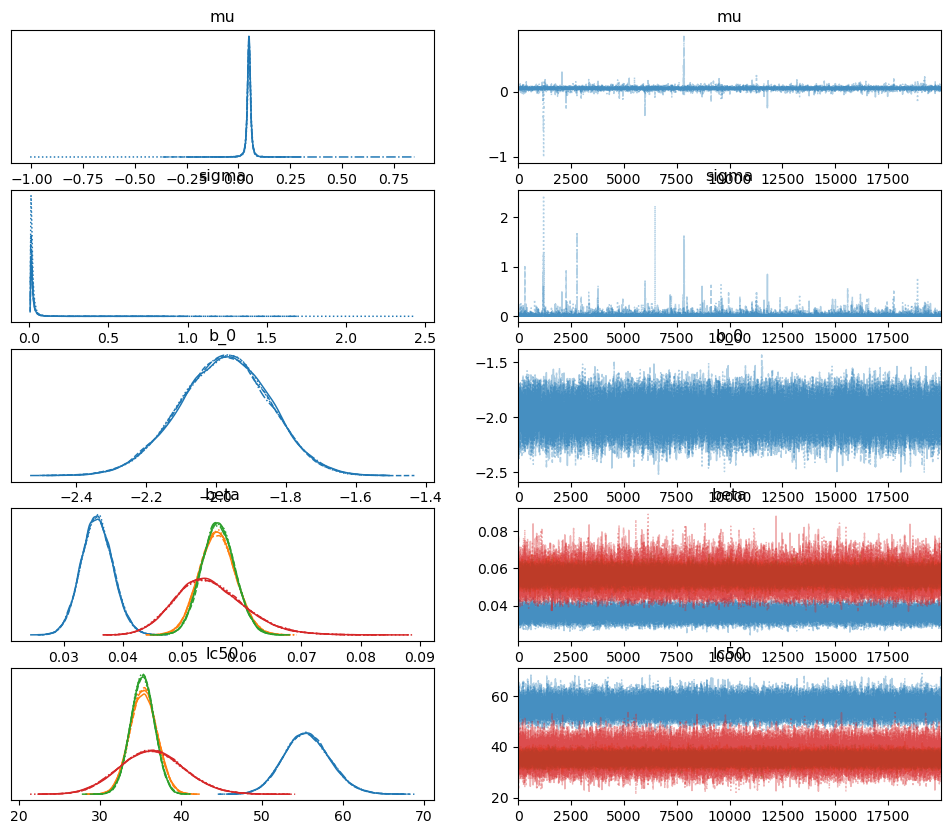

In [24]:
#arviz model diagnostics
az.plot_trace(data=fit, divergences=None)

#calculate R_hat to analyze convergence between chains. Values above 1 indicate lack of convergence.
print(az.rhat(data=fit))

In [ ]:
#posterior predicitons
draws=fit.draws_pd()
#fit.draws_pd().assign(yhat (1) / ( 1 + np.exp( -1*( draws['b_0'] + draws['b] ))))
draws.head(10)


0   -1.75897
1   -1.95309
2   -1.92625
3   -1.82774
4   -1.99794
5   -2.18737
6   -2.07567
7   -1.92813
8   -2.10834
9   -2.03608
Name: b_0, dtype: float64